# Hierarchical Clustering

## Importing packages and defining functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import os
import plotly.graph_objects as go

# Create outputs directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Import the dataset
dataset = pd.read_csv('raw_data/Mall_Customers.csv')

# Convert Genre to numeric
dataset['Genre'] = np.where(dataset['Genre'] == 'Male', 0, 1)

# Function to plot dendrogram
def plot_dendrogram(X, title):
    plt.figure(figsize=(10, 7))
    dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
    plt.title(title, fontsize=20)
    plt.xlabel('Samples', fontsize=14)
    plt.ylabel('Euclidean distances', fontsize=14)
    plt.savefig(f'outputs/{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Function to perform hierarchical clustering and visualize results
def perform_hierarchical_clustering(X, n_clusters, feature_names, title):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Plot dendrogram
    plot_dendrogram(X_scaled, f'{title} Dendrogram')
    
    # Perform hierarchical clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    y_hc = hc.fit_predict(X_scaled)
    
    # Visualize clusters
    if X.shape[1] == 2:
        plt.figure(figsize=(10, 7))
        for i in range(n_clusters):
            plt.scatter(X[y_hc == i, 0], X[y_hc == i, 1], s=100, label=f'Cluster {i+1}')
        plt.title(f'{title} Clusters', fontsize=20)
        plt.xlabel(feature_names[0], fontsize=14)
        plt.ylabel(feature_names[1], fontsize=14)
        plt.legend()
        plt.savefig(f'outputs/{title.lower().replace(" ", "_")}_clusters.png', dpi=300, bbox_inches='tight')
        plt.show()
    elif X.shape[1] == 3:
        fig = go.Figure(data=[go.Scatter3d(
            x=X[:, 0],
            y=X[:, 1],
            z=X[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=y_hc,
                colorscale='Viridis',
                opacity=0.8
            ),
            text=[f"{feature_names[0]}: {X[i, 0]}<br>{feature_names[1]}: {X[i, 1]}<br>{feature_names[2]}: {X[i, 2]}" for i in range(len(X))],
            hoverinfo='text'
        )])

        fig.update_layout(
            title=f'{title} Clusters',
            scene=dict(
                xaxis_title=feature_names[0],
                yaxis_title=feature_names[1],
                zaxis_title=feature_names[2]
            ),
            width=900,
            height=700,
        )

        fig.write_html(f"outputs/{title.lower().replace(' ', '_')}_clusters_interactive.html")
        fig.show()
    
    return y_hc, X_scaled

# Function to create summary table
def create_summary_table(dataset, y_clusters, features):
    dataset['Cluster'] = y_clusters
    
    def cluster_summary(cluster_data):
        summary = {'Size': len(cluster_data)}
        
        if 'Genre' in features:
            summary['Male %'] = (cluster_data['Genre'] == 0).mean() * 100
            summary['Female %'] = (cluster_data['Genre'] == 1).mean() * 100
        
        for feature in features:
            if feature != 'Genre':
                summary[f'{feature} (Mean)'] = cluster_data[feature].mean()
                summary[f'{feature} (Median)'] = cluster_data[feature].median()
        
        return pd.Series(summary)

    cluster_summaries = dataset.groupby('Cluster').apply(cluster_summary).reset_index()
    cluster_summaries = cluster_summaries.sort_values('Cluster')
    
    # Define column order based on features
    column_order = ['Cluster', 'Size']
    if 'Genre' in features:
        column_order.extend(['Male %', 'Female %'])
    for feature in features:
        if feature != 'Genre':
            column_order.extend([f'{feature} (Mean)', f'{feature} (Median)'])
    
    cluster_summaries = cluster_summaries[column_order]
    
    # Apply styling to the dataframe
    style_format = {
        'Size': '{:,.0f}',
        'Male %': '{:.1f}%',
        'Female %': '{:.1f}%',
        'Age (Mean)': '{:.1f}',
        'Age (Median)': '{:.1f}',
        'Annual Income (k$) (Mean)': '${:,.0f}k',
        'Annual Income (k$) (Median)': '${:,.0f}k',
        'Spending Score (1-100) (Mean)': '{:.1f}',
        'Spending Score (1-100) (Median)': '{:.1f}'
    }
    
    styled_df = cluster_summaries.style.format(style_format)
    
    styled_df = styled_df.background_gradient(subset=['Size'], cmap='Blues')
    
    if 'Genre' in features:
        styled_df = styled_df.background_gradient(subset=['Male %', 'Female %'], cmap='RdYlGn')
    
    for feature in features:
        if feature != 'Genre':
            styled_df = styled_df.background_gradient(
                subset=[f'{feature} (Mean)', f'{feature} (Median)'],
                cmap='YlOrRd' if feature == 'Age' else 'Greens' if feature == 'Annual Income (k$)' else 'PuBu'
            )
    
    styled_df = styled_df.set_properties(**{'text-align': 'center'})\
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('color', 'black'), ('font-weight', 'bold')]},
            {'selector': 'td', 'props': [('padding', '8px')]},
            {'selector': '', 'props': [('border-collapse', 'collapse'), ('border', '1px solid #ddd')]}
        ])
    
    return styled_df

# 2D Hierarchical Clustering (Annual Income, Spending Score)

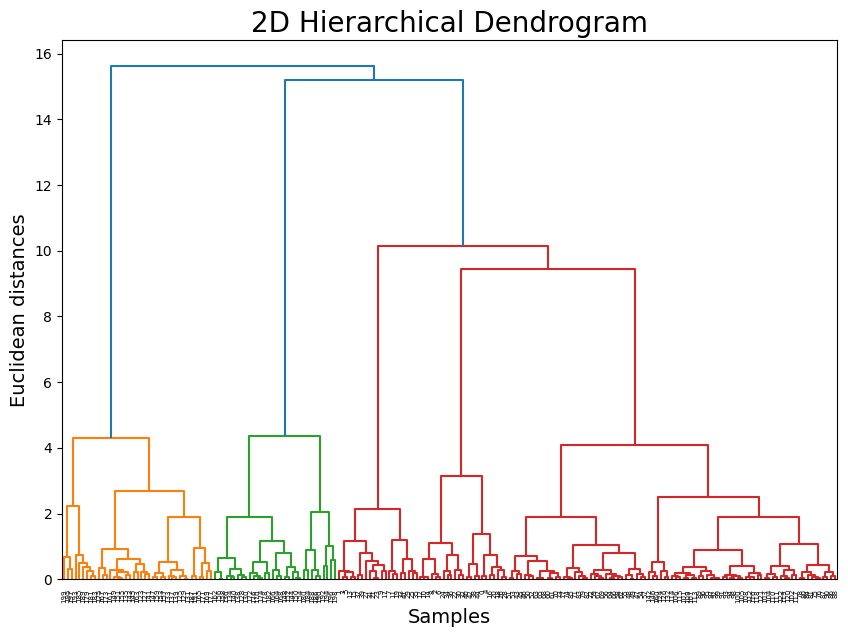

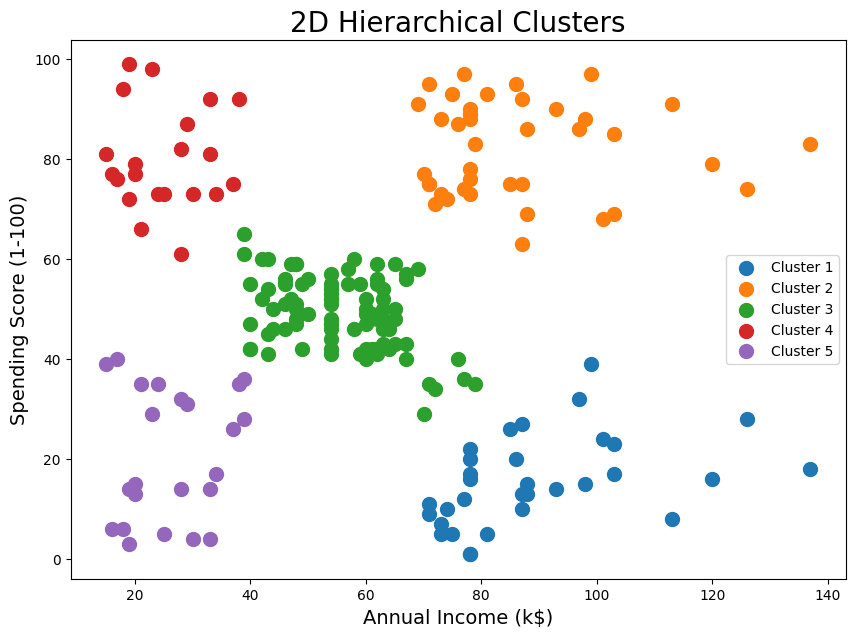

/tmp/ipykernel_120340/374924598.py:102: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_summaries = dataset.groupby('Cluster').apply(cluster_summary).reset_index()


In [2]:
# 2D Hierarchical Clustering
X_2d = dataset.iloc[:, [3, 4]].values
feature_names_2d = ['Annual Income (k$)', 'Spending Score (1-100)']

y_hc_2d, X_scaled_2d = perform_hierarchical_clustering(X_2d, n_clusters=5, feature_names=feature_names_2d, title='2D Hierarchical')

# Create summary table
styled_df_2d = create_summary_table(dataset, y_hc_2d, ['Annual Income (k$)', 'Spending Score (1-100)'])
display(styled_df_2d)
styled_df_2d.to_html('outputs/2d_hierarchical_summary_table.html')

## 3D Clustering (Age, Annual Income, Spending score)

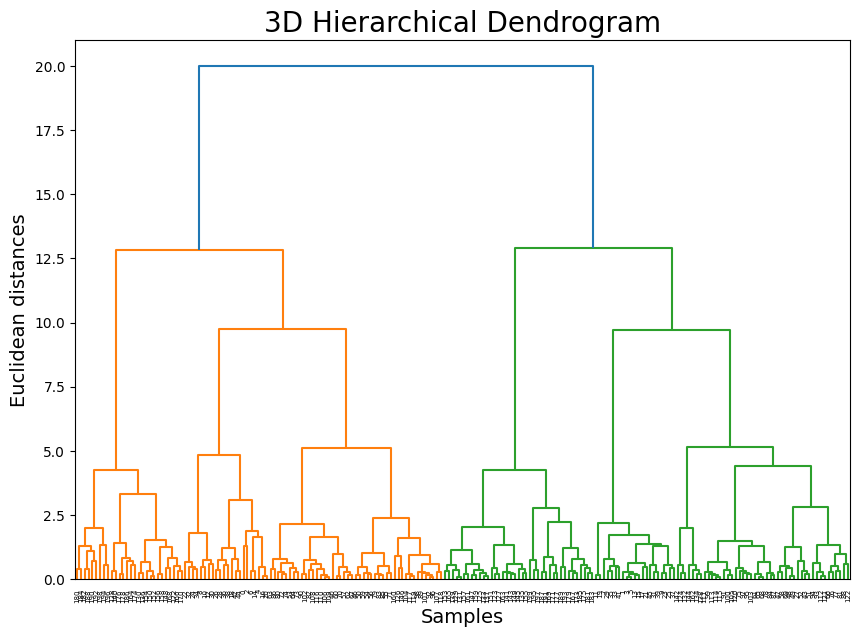

/tmp/ipykernel_120340/374924598.py:102: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [3]:
# 3D Hierarchical Clustering
X_3d = dataset.iloc[:, [2, 3, 4]].values
feature_names_3d = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

y_hc_3d, X_scaled_3d = perform_hierarchical_clustering(X_3d, n_clusters=6, feature_names=feature_names_3d, title='3D Hierarchical')

# Create summary table
styled_df_3d = create_summary_table(dataset, y_hc_3d, ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
display(styled_df_3d)
styled_df_3d.to_html('outputs/3d_hierarchical_summary_table.html')

## 4D Clustering (Genre, Age, Annual Income, Spending score)

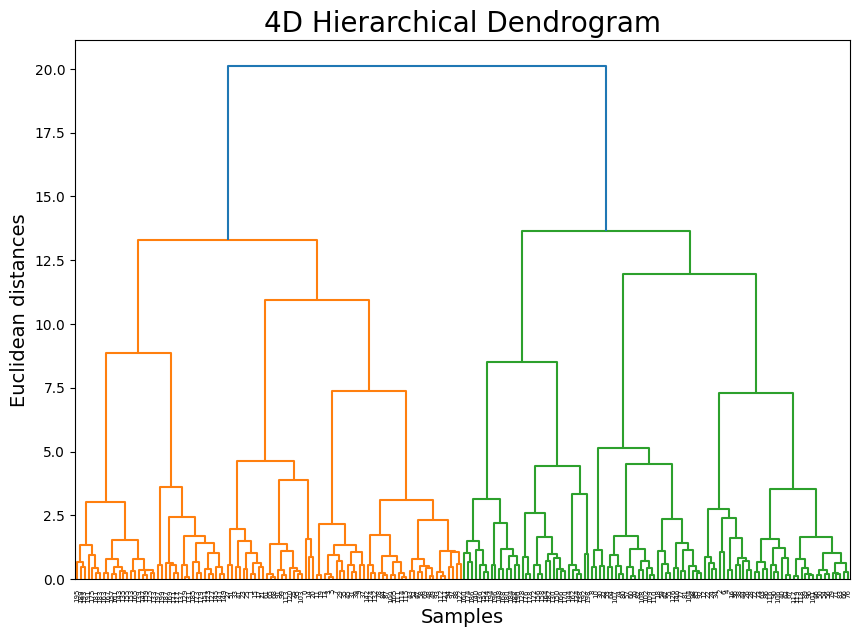

/tmp/ipykernel_120340/374924598.py:102: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



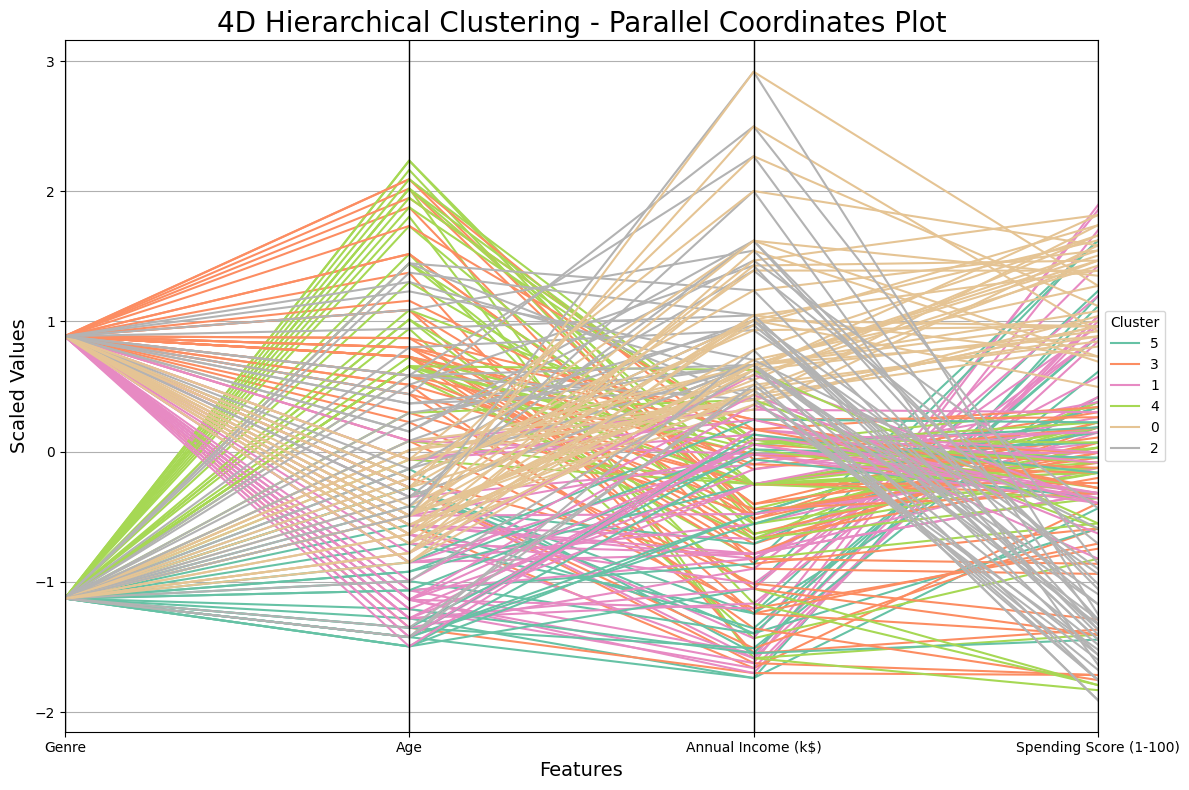

In [4]:
# 4D Hierarchical Clustering
X_4d = dataset.iloc[:, [1, 2, 3, 4]].values
feature_names_4d = ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

y_hc_4d, X_scaled_4d = perform_hierarchical_clustering(X_4d, n_clusters=6, feature_names=feature_names_4d, title='4D Hierarchical')

# Create summary table
styled_df_4d = create_summary_table(dataset, y_hc_4d, ['Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
display(styled_df_4d)
styled_df_4d.to_html('outputs/4d_hierarchical_summary_table.html')

# Visualize 4D results using parallel coordinates plot
plt.figure(figsize=(12, 8))
pd.plotting.parallel_coordinates(
    pd.DataFrame(X_scaled_4d, columns=feature_names_4d).assign(Cluster=y_hc_4d),
    'Cluster',
    colormap=plt.cm.Set2
)
plt.title('4D Hierarchical Clustering - Parallel Coordinates Plot', fontsize=20)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Scaled Values', fontsize=14)
plt.legend(title='Cluster', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('outputs/4d_hierarchical_parallel_coordinates.png', dpi=300, bbox_inches='tight')
plt.show()